In [2]:
# Import libraries
import numpy as np
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns


from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import word_tokenize


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import plotly.graph_objs as go


In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### GOAL: Cluster the title data using mini-batch k-means and observe the clusters formed using PCA. Check their Silhouette scores. Also create an year-wise plot of the number of papers published per cluster which will tell us the trending topic of that year.

Preprocess the text data for each row in the column title. Below function perform the cleaning of the text data. It removes the following:-
* Remove multiple spaces
* Remove punctuations
* Remove special characters
* Remove stopwords
* Remove digits
* Remove single characters or short tokens
* Remove elipses (...)
* Convert to lowercase


In [4]:
def clean_text_data(text, tokenizer):
    # Load the stopwords
    stop_words = set(stopwords.words("english"))
    
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ... and ... at the end of the content
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words with space
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation 

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stop_words]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove tokens with length <= 1
    return tokens


Make a new column in the dataframe named "tokens" for storing the cleaned title data.

In [5]:
text_columns = ["title"]

# Load data
df_original = pd.read_csv('papers.csv')

# Make copy of original dataframe
df_copy = df_original.drop_duplicates().copy()

# Convert columns to string
for col in text_columns:
    df_copy[col] = df_copy[col].astype(str)

# Make new column with preprocessed text as tokens
df_copy["tokens"] = df_copy["title"].map(lambda x: clean_text_data(x, word_tokenize))

# Remove duplicated after preprocessing from tokens column
df_copy = df_copy.drop_duplicates(subset=["tokens"])

# Filter out rows with empty tokens
non_empty_tokens = df_copy["tokens"].apply(lambda x: len(x) > 0)
df_copy = df_copy[non_empty_tokens]

# Select desired columns
df_copy = df_copy[["title", "tokens", "year", "abstract"]]

# Reset index
df_copy = df_copy.reset_index(drop=True)

# Get values of title and tokens
title_values = df_copy["title"].values
tokens_values = df_copy["tokens"].values

# Save csv file
df_copy.to_csv("Cleaned_DF.csv", index=False)

This is the look of our dataframe after preprocessing the title data.

In [6]:
df_cleaned = pd.read_csv("Cleaned_DF.csv")

In [7]:
# Train word2vec model
model = Word2Vec(sentences=tokens_values, vector_size=100)

 #### Get word vectors for each token in list_of_tokens. Use the Genism's Word Embedding model to create vectors. The function returns a list of vectors for each row title.

In [8]:
# Get word vectors for each token in list_of_tokens
def vectorize(token_values, model):
    
    features = []

    for tokens in token_values:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_tokens = vectorize(tokens_values, model=model)

## Perform mini-batch k-means clustering on the word vectors. The function returns the model and the cluster labels.

In [9]:
def mbkmeans_clusters(X, num_clusters, mb):
    # X: Matrix of features.
    # mb: Size of mini-batches.

    mbkm = MiniBatchKMeans(n_clusters=num_clusters, batch_size=mb).fit(X)
    print(f"Cluster value = {num_clusters}")
    print(f"Silhouette coefficient: {silhouette_score(X, mbkm.labels_):0.2f}")
    sample_silhouette_values = silhouette_samples(X, mbkm.labels_)

    cluster_count = {}
    for i in range(num_clusters):
        cluster_match_label = sample_silhouette_values[mbkm.labels_ == i]
        cluster_count[i] = cluster_match_label.shape[0]
        print(f" Number of papers in Cluster{i} : {cluster_count[i]}")
        
    return mbkm, mbkm.labels_

In [10]:
mbkmeans_model, cluster_labels = mbkmeans_clusters(X=vectorized_tokens, num_clusters = 10, mb=500)


df_clusters = pd.DataFrame({
    "title": title_values,
    "tokens": [" ".join(text) for text in tokens_values],
    "cluster": cluster_labels,
    "year": df_cleaned["year"].values,
    "title": df_cleaned["title"].values,
    "abstract": df_cleaned["abstract"].values
})

# save csv file
df_clusters.to_csv("Clustering_Results.csv", index=False)

Cluster value = 10
Silhouette coefficient: 0.38
 Number of papers in Cluster0 : 1465
 Number of papers in Cluster1 : 975
 Number of papers in Cluster2 : 96
 Number of papers in Cluster3 : 1611
 Number of papers in Cluster4 : 904
 Number of papers in Cluster5 : 437
 Number of papers in Cluster6 : 1796
 Number of papers in Cluster7 : 1215
 Number of papers in Cluster8 : 792
 Number of papers in Cluster9 : 389


In [11]:
df_clustering_results = pd.read_csv("Clustering_Results.csv")

We chose the cluster size to be 10. We observed how the silhouette score changes with the cluster size. We found that the silhouette score is maximum for cluster size 10. The silhouette score is 0.38 which is a good score and very near to 1. This means clustering is performed at a good level.

## Give label to each cluster as per the title of the centroid in that particular cluster.

#### For each cluster, get the title of the centroid of that particular cluster. The function maps centroid of each cluster to the title of the paper. This represents the most similar title to that cluster.

In [12]:
cluster_dict = {}
for i in range(10):
    most_representative_tokens = np.argsort(np.linalg.norm(vectorized_tokens - mbkmeans_model.cluster_centers_[i], axis=1))
    print(f"Cluster {i}", ":",title_values[most_representative_tokens[0]])
    cluster_dict[i] = title_values[most_representative_tokens[0]]

Cluster 0 : Keeping Your Distance: Solving Sparse Reward Tasks Using Self-Balancing Shaped Rewards
Cluster 1 : Multiple Paired Forward-Inverse Models for Human Motor Learning and Control
Cluster 2 : On Bootstrapping the ROC Curve
Cluster 3 : Learning and using language via recursive pragmatic reasoning about other agents
Cluster 4 : Tangent: Automatic differentiation using source-code transformation for dynamically typed array programming
Cluster 5 : Efficient Learning of Sparse Representations with an Energy-Based Model
Cluster 6 : Nonnegative dictionary learning in the exponential noise model for adaptive music signal representation
Cluster 7 : Computation of Similarity Measures for Sequential Data using Generalized Suffix Trees
Cluster 8 : An Efficient Clustering Algorithm Using Stochastic Association Model and Its Implementation Using Nanostructures
Cluster 9 : Solid Harmonic Wavelet Scattering: Predicting Quantum Molecular Energy from Invariant Descriptors of 3D  Electronic Densit

## Summarize the labels for each cluster using top 15 words. 

In [13]:
def find_topWords_and_Summarize(i):
    # Filter the rows by cluster label
    cluster_df_0 = df_clusters[df_clusters['cluster'] == i]

    # Concatenate the token lists
    tokens = []
    for row in cluster_df_0['tokens']:
        tokens += row.split()

    # Calculate the frequency distribution
    freq_dist = FreqDist(tokens)
    # print(freq_dist)
    # Get the 10 most common words
    top_words = [word for word, frequency in freq_dist.most_common(15)]

    # Convert the list of words into a string
    summary = " ".join(top_words)

    print(f"Summary for Cluster {i}",summary)

for i in range(10):
    find_topWords_and_Summarize(i)

Summary for Cluster 0 learning networks neural using model models network optimization via image based data deep multi classification
Summary for Cluster 1 learning neural networks models using bayesian model deep based data via optimization inference analysis gaussian
Summary for Cluster 2 replay hindsight experience languages music compute balancing observation neuromorphic regularizing mobile environment occams razor impact
Summary for Cluster 3 learning neural networks models using via based model deep multi network inference data optimization linear
Summary for Cluster 4 learning neural networks model models using sparse optimal clustering classification network algorithm based bandits multi
Summary for Cluster 5 learning networks neural models model deep using optimization stochastic reinforcement inference data efficient bayesian analysis
Summary for Cluster 6 learning neural networks models using model data deep inference bayesian analysis network via estimation based
Summary f

From the Summary analysis of the different clusters, we can see that there are various research areas within the field of machine learning and artificial intelligence that are being explored by researchers. Cluster 0, 3, and 6 seem to be the most active and densely populated clusters with the highest number of papers published from 2016 to 2019.

Cluster 0 focuses on using self-balancing shaped rewards to solve sparse reward tasks, Cluster 3 focuses on learning and using language via recursive pragmatic reasoning about other agents, and Cluster 6 focuses on non-negative dictionary learning for adaptive music signal representation.

Other clusters, such as Cluster 1, 2, 4, 5, 7, 8, and 9, explore topics such as neural networks, deep learning, optimization, Bayesian models, clustering, stochastic reinforcement, efficient estimation, and more. These clusters indicate a diverse range of research interests and approaches within the field of machine learning and artificial intelligence.

Overall, the clustering analysis reveals the diversity of research interests and the prevalence of different research areas within machine learning and artificial intelligence.

## Plot the clusters using PCA

#### This will show us how the clusters are scattered in the space. Since our vector dimensions is (1, 100) we will reduce it to 2 dimensions using PCA and plot the clusters for good visualization.

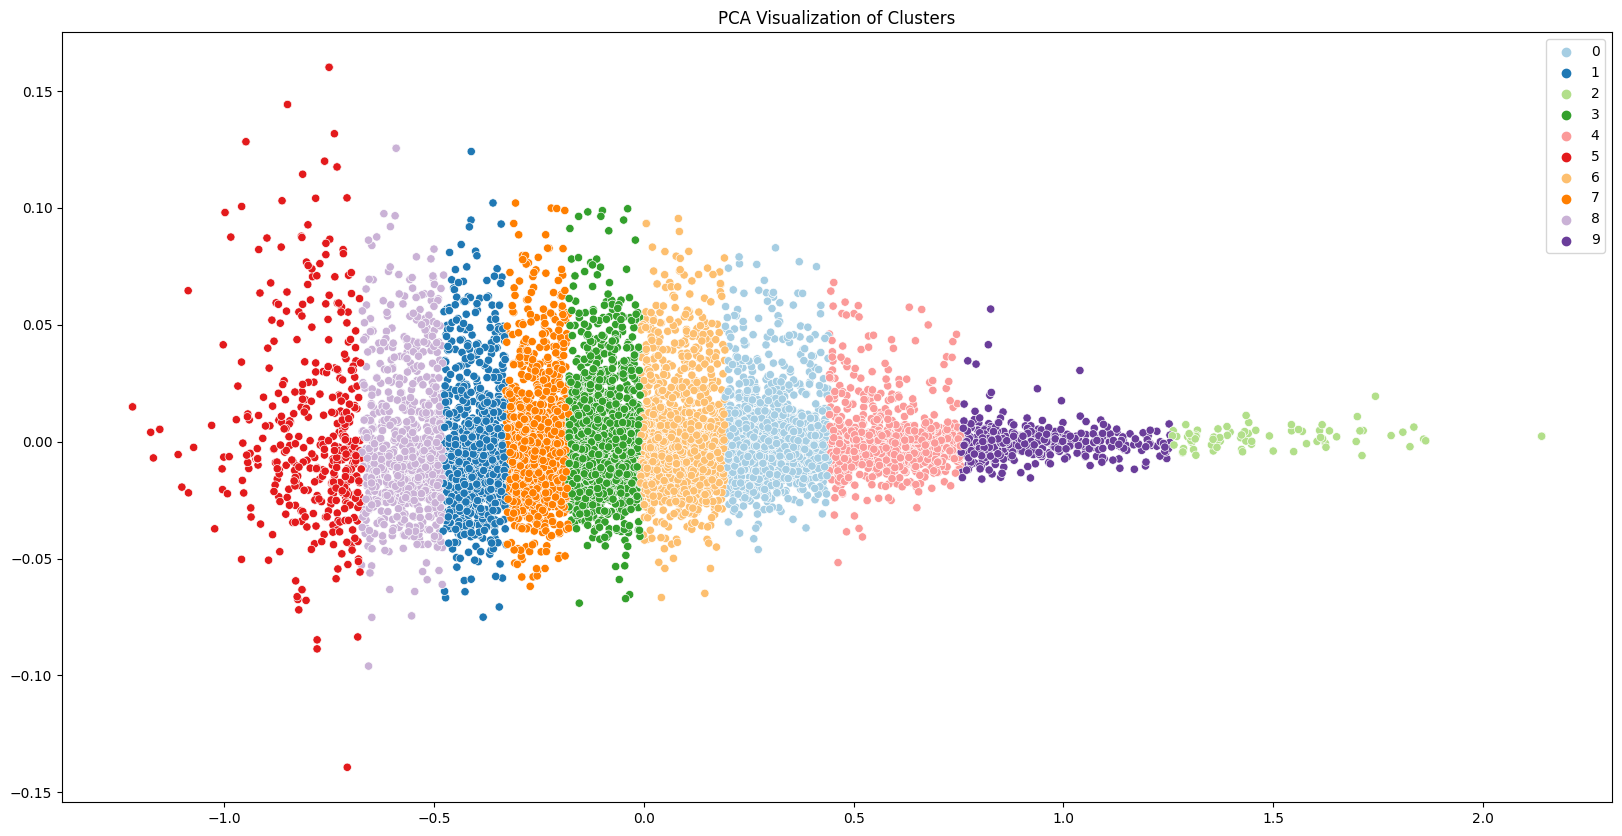

Cluster 0: Keeping Your Distance: Solving Sparse Reward Tasks Using Self-Balancing Shaped Rewards
Cluster 1: Multiple Paired Forward-Inverse Models for Human Motor Learning and Control
Cluster 2: On Bootstrapping the ROC Curve
Cluster 3: Learning and using language via recursive pragmatic reasoning about other agents
Cluster 4: Tangent: Automatic differentiation using source-code transformation for dynamically typed array programming
Cluster 5: Efficient Learning of Sparse Representations with an Energy-Based Model
Cluster 6: Nonnegative dictionary learning in the exponential noise model for adaptive music signal representation
Cluster 7: Computation of Similarity Measures for Sequential Data using Generalized Suffix Trees
Cluster 8: An Efficient Clustering Algorithm Using Stochastic Association Model and Its Implementation Using Nanostructures
Cluster 9: Solid Harmonic Wavelet Scattering: Predicting Quantum Molecular Energy from Invariant Descriptors of 3D  Electronic Densities


<Figure size 640x480 with 0 Axes>

In [14]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(vectorized_tokens)

plt.figure(figsize=(20, 10))
sns.scatterplot(x=pca_transformed[:,0], y=pca_transformed[:,1], hue=cluster_labels, legend='full', palette='Paired')
plt.title('PCA Visualization of Clusters')
plt.show() 
plt.savefig('PCA Visualization of Clusters.png')

for key, value in cluster_dict.items():
    print(f"Cluster {key}:", value)

In [15]:
df_clusters

,title,tokens,cluster,year,abstract
0,Bit-Serial Neural Networks,bit serial neural networks,3,1987,NaN
1,Connectivity Versus Entropy,connectivity versus entropy,4,1987,NaN
2,The Hopfield Model with Multi-Level Neurons,hopfield model multi level neurons,3,1987,NaN
3,How Neural Nets Work,neural nets work,0,1987,NaN
4,Spatial Organization of Neural Networks: A Pro...,spatial organization neural networks probabili...,1,1987,NaN
...,...,...,...,...,...
9675,Discrete Object Generation with Reversible Ind...,discrete object generation reversible inductiv...,4,2019,The success of generative modeling in continuo...
9676,Adaptively Aligned Image Captioning via Adapti...,adaptively aligned image captioning via adapti...,1,2019,Recent neural models for image captioning usua...
9677,Fully Dynamic Consistent Facility Location,fully dynamic consistent facility location,4,2019,We consider classic clustering problems in ful...
9678,Efficient Rematerialization for Deep Networks,efficient rematerialization deep networks,5,2019,"When training complex neural networks, memory ..."


In [17]:
# Group the data by year and clusters
df_grouped = df_clusters.groupby(['year', 'cluster']).size().reset_index(name='counts')

# Create a list of colors for the clusters
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a trace for each cluster
traces = []
for i in range(10):
    trace = go.Bar(
        x=df_grouped[df_grouped['cluster'] == i]['year'],
        y=df_grouped[df_grouped['cluster'] == i]['counts'],
        name=f'Cluster {i}',
        marker=dict(color=colors[i])
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='Yearly distribution of papers by cluster',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Count of papers for each Cluster'),
    barmode='stack'

)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)
fig.show()

for key, value in cluster_dict.items():
    print(f"Cluster {key}:", value)


Cluster 0: Keeping Your Distance: Solving Sparse Reward Tasks Using Self-Balancing Shaped Rewards
Cluster 1: Multiple Paired Forward-Inverse Models for Human Motor Learning and Control
Cluster 2: On Bootstrapping the ROC Curve
Cluster 3: Learning and using language via recursive pragmatic reasoning about other agents
Cluster 4: Tangent: Automatic differentiation using source-code transformation for dynamically typed array programming
Cluster 5: Efficient Learning of Sparse Representations with an Energy-Based Model
Cluster 6: Nonnegative dictionary learning in the exponential noise model for adaptive music signal representation
Cluster 7: Computation of Similarity Measures for Sequential Data using Generalized Suffix Trees
Cluster 8: An Efficient Clustering Algorithm Using Stochastic Association Model and Its Implementation Using Nanostructures
Cluster 9: Solid Harmonic Wavelet Scattering: Predicting Quantum Molecular Energy from Invariant Descriptors of 3D  Electronic Densities



Based on the analysis you provided, we can infer that the topics covered by Cluster 0, Cluster 3, and Cluster 6 are the most popular research areas in the years 2016-2019.

Cluster 0, which deals with "Keeping Your Distance: Solving Sparse Reward Tasks Using Self-Balancing Shaped Rewards," suggests that researchers were interested in developing new ways to address the challenge of learning from sparse rewards in reinforcement learning problems. This could have important implications for developing more effective and efficient artificial intelligence systems.

Cluster 3, which focuses on "Learning and using language via recursive pragmatic reasoning about other agents," implies that researchers were exploring new ways to enable machines to learn language and communicate with humans more effectively. This is particularly important given the growing importance of natural language processing in various domains.

Cluster 6, which deals with "Nonnegative dictionary learning in the exponential noise model for adaptive music signal representation," suggests that researchers were interested in developing new techniques for music signal processing. This could have important applications in fields such as music information retrieval and music recommendation systems.

Overall, the analysis suggests that the research topics covered by Cluster 0, Cluster 3, and Cluster 6 were of significant interest to researchers in the years 2016-2019 and could have important implications for the development of new technologies and systems in the future.

Apart from that we could see an increase in the number of papers published over the years which is pretty obvious.
